<a href="https://colab.research.google.com/github/Safa30/CSE475_Machine_Learning/blob/main/Lab/lab_2/Lab2_Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 – Unsupervised Learning
## Mall Customer Segmentation using K-Means, DBSCAN, and GMM

---
**Objective:** Apply and compare three unsupervised clustering algorithms — K-Means, DBSCAN, and GMM — on the Mall Customers dataset to identify meaningful customer segments that can inform marketing strategy.

**Dataset:** Mall_Customers.csv — 200 customers with features: Age, Annual Income (k$), Spending Score (1–100), and Gender.

---

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.signal import argrelextrema

# Optional: install kneed if available
try:
    from kneed import KneeLocator
    KNEED_AVAILABLE = True
except ImportError:
    KNEED_AVAILABLE = False
    print("Note: 'kneed' not installed. Using manual second-derivative elbow detection instead.")

print("All libraries loaded successfully.")

Note: 'kneed' not installed. Using manual second-derivative elbow detection instead.
All libraries loaded successfully.


In [2]:
!pip install kneed -q

## 2. Load the Dataset

In [3]:
!gdown --id 1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf
To: /content/Mall_Customers.csv
100% 3.98k/3.98k [00:00<00:00, 7.91MB/s]


In [4]:
df = pd.read_csv("/content/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## 3. Data Overview and Initial Inspection

In [5]:
# Display basic information about the DataFrame
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None

In [7]:
# Check for missing values
display(df.isnull().sum())

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [8]:
# Display descriptive statistics for numerical columns
display(df.describe())

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


**Summary:**  
The dataset contains **200 entries** and **5 columns**. There are **no missing values** — no imputation required. `CustomerID` is a row identifier with no predictive value and will be dropped. Numerical ranges are realistic: ages 18–70, incomes 15k–137k, spending scores 1–99. `Gender` is categorical and will be label-encoded for use in K-Means and GMM.

## 4. Exploratory Data Analysis (EDA)

### 4.1 Distribution of Numerical Features

I visualized Age, Annual Income, and Spending Score using histograms with KDE overlays to understand their distributions.

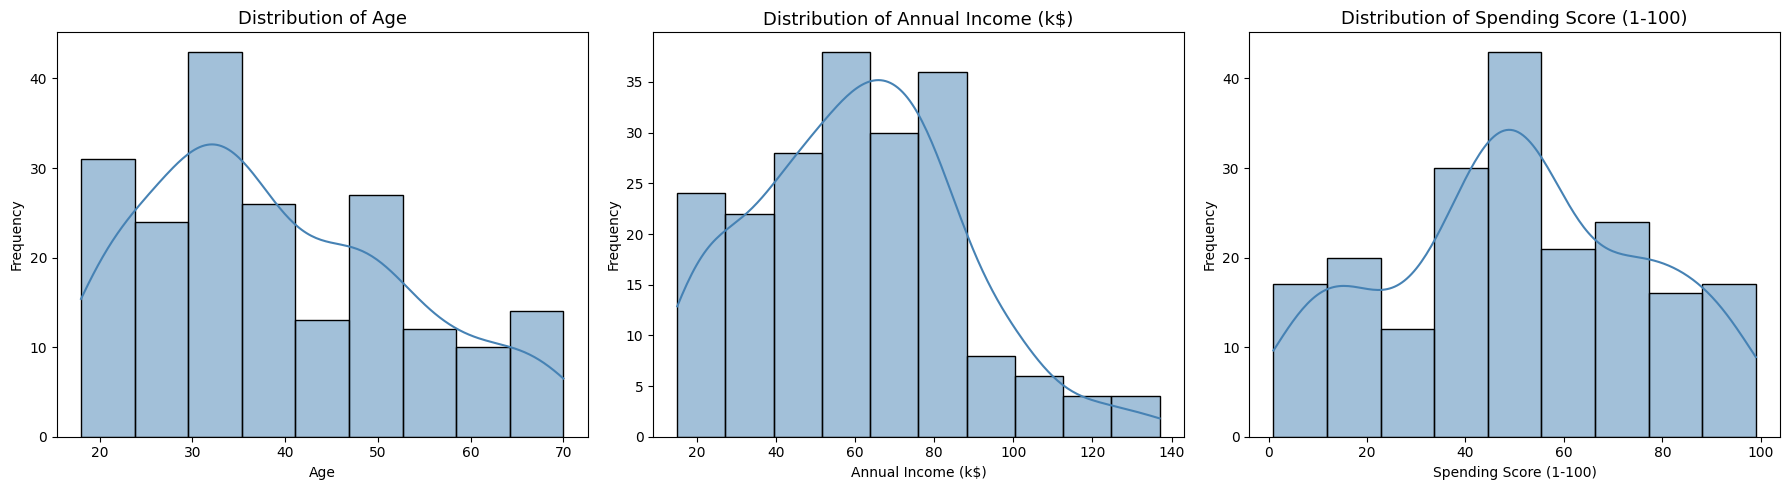

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df['Age'], kde=True, ax=ax[0], color='steelblue')
ax[0].set_title('Distribution of Age', fontsize=13)
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')

sns.histplot(df['Annual Income (k$)'], kde=True, ax=ax[1], color='steelblue')
ax[1].set_title('Distribution of Annual Income (k$)', fontsize=13)
ax[1].set_xlabel('Annual Income (k$)')
ax[1].set_ylabel('Frequency')

sns.histplot(df['Spending Score (1-100)'], kde=True, ax=ax[2], color='steelblue')
ax[2].set_title('Distribution of Spending Score (1-100)', fontsize=13)
ax[2].set_xlabel('Spending Score (1-100)')
ax[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Interpretation:**
- **Age:** Right-skewed distribution, concentrated between 25–45. Customers older than 55 are underrepresented.
- **Annual Income:** Approximately bell-shaped, centred around 55–65k. A few high-income outliers exist above 120k.
- **Spending Score:** Notable bimodality with peaks around 40–50 and 75–90, strongly suggesting at least two distinct spending behaviours that clustering should capture.

### 4.2 Gender Distribution

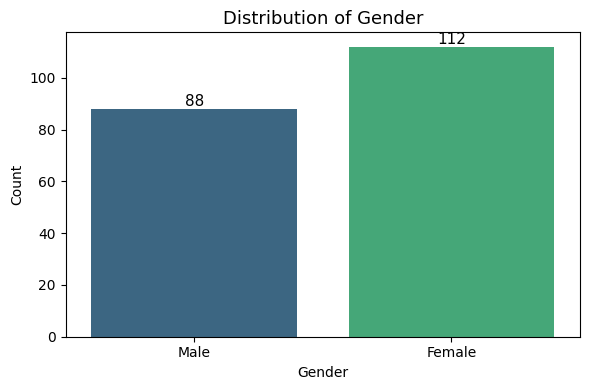

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender', hue='Gender', palette='viridis', legend=False)
plt.title('Distribution of Gender', fontsize=13)
plt.xlabel('Gender')
plt.ylabel('Count')
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                       ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

**Interpretation:** The dataset has a slight gender imbalance — approximately **112 female** and **88 male** customers (~56% female). While this won't significantly bias clustering, it's good practice to encode gender for possible inclusion in feature space.

### 4.3 Relationships Between Key Features

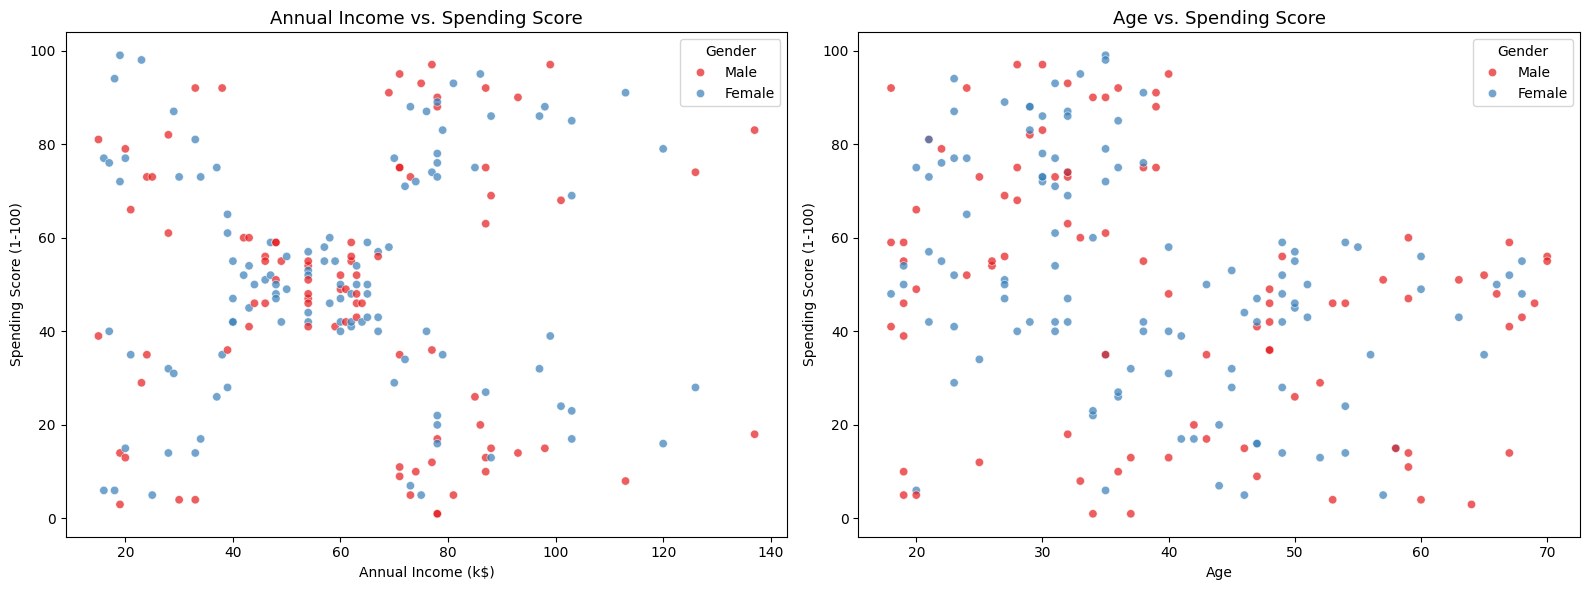

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Gender', palette='Set1', ax=ax[0], alpha=0.7)
ax[0].set_title('Annual Income vs. Spending Score', fontsize=13)
ax[0].set_xlabel('Annual Income (k$)')
ax[0].set_ylabel('Spending Score (1-100)')

sns.scatterplot(data=df, x='Age', y='Spending Score (1-100)',
                hue='Gender', palette='Set1', ax=ax[1], alpha=0.7)
ax[1].set_title('Age vs. Spending Score', fontsize=13)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()

**Interpretation:**

 **Annual Income vs. Spending Score:** Five natural groups are visible —
- Low income+high spending (impulse buyers)
- High income+high spending (VIPs)
- High income+low spending (conservative earners)
- Low income+low spending (budget customers)
- Medium income+medium spending (average majority).

This visual structure strongly motivates choosing K=5.

**Age vs. Spending Score:** Younger customers (18–35) span all spending levels. For customers over 40, spending scores cluster around moderate values — the relationship is noisy and non-linear.

### 4.4 Correlation Heatmap

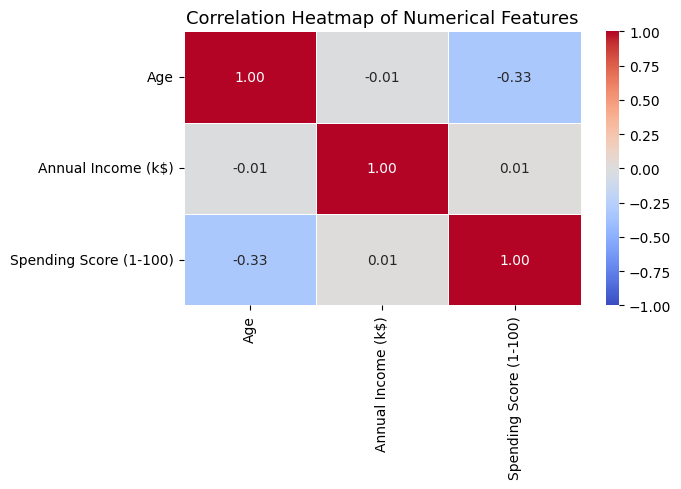

In [12]:
numerical_df = df.select_dtypes(include=np.number).drop(columns=['CustomerID'])
plt.figure(figsize=(7, 5))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Features', fontsize=13)
plt.tight_layout()
plt.show()

**Interpretation:**
- **Age & Spending Score: –0.33** — Moderate negative correlation. Younger customers spend more freely; older customers are more conservative.
- **Annual Income & Spending Score: ~0.01** — Near-zero *linear* correlation. This does **not** mean income is irrelevant — the scatter plot reveals a non-linear, cluster-shaped relationship. This is precisely why clustering outperforms regression here.
- **Age & Annual Income: –0.01** — No meaningful linear relationship.

> The near-zero linear correlations between Income and Spending Score **validate** the use of unsupervised clustering: the true structure is geometric, not linear.

## 5. Data Preprocessing for Clustering

Preprocessing steps:
1. Drop `CustomerID` (non-informative identifier)
2. Rename columns for cleaner code
3. Encode `Gender` using Label Encoding
4. Detect and report outliers using IQR method
5. Scale numerical features using `StandardScaler`
6. Build the final feature matrix `df_processed`

> **Important design decision**: `Gender_Encoded` (binary 0/1) is included as an extra feature for K-Means and GMM (which work in Euclidean space across all dimensions). However, for DBSCAN — which is distance-sensitive — we will use **only the 3 scaled continuous features** (Age, Annual Income, Spending Score) to avoid density distortion from a mixed binary variable. This is explained further in the DBSCAN section.

In [13]:
# Drop irrelevant identifier column
df.drop(columns=['CustomerID'], inplace=True)

# Rename columns for cleaner variable names
df.rename(columns={
    'Annual Income (k$)' : 'Annual_Income',
    'Spending Score (1-100)' : 'Spending_Score'
}, inplace=True)

print("Remaining columns:", df.columns.tolist())
df.head()

Remaining columns: ['Gender', 'Age', 'Annual_Income', 'Spending_Score']


,Gender,Age,Annual_Income,Spending_Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode Gender: Female → 0, Male → 1
le = LabelEncoder()
df['Gender_Encoded'] = le.fit_transform(df['Gender'])

print("Gender encoding counts:")
print(df[['Gender', 'Gender_Encoded']].value_counts())

Gender encoding counts:
Gender  Gender_Encoded
Female  0                 112
Male    1                  88
Name: count, dtype: int64


In [15]:
# Outlier detection using IQR method
def detect_outliers(data, col):
    Q1, Q3 = data[col].quantile(0.25), data[col].quantile(0.75)
    IQR = Q3 - Q1
    n_out = ((data[col] < Q1 - 1.5 * IQR) | (data[col] > Q3 + 1.5 * IQR)).sum()
    print(f'  {col}: {n_out} outlier(s) detected')

print('Outlier Detection (IQR Method):')
for col in ['Age', 'Annual_Income', 'Spending_Score']:
    detect_outliers(df, col)

print('\nConclusion: Minimal outliers — no removal needed. Dataset is clean.')

Outlier Detection (IQR Method):
  Age: 0 outlier(s) detected
  Annual_Income: 2 outlier(s) detected
  Spending_Score: 0 outlier(s) detected

Conclusion: Minimal outliers — no removal needed. Dataset is clean.


In [16]:
# Feature scaling using StandardScaler
# Applied ONLY to the 3 continuous features — NOT to Gender_Encoded
# StandardScaler transforms each feature to: mean=0, std=1
scaler = StandardScaler()
numeric_features = ['Age', 'Annual_Income', 'Spending_Score']

df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

print('Scaled data sample (continuous features):')
print(df_scaled[numeric_features].head())
print(f'\nMeans after scaling: {df_scaled[numeric_features].mean().round(6).values}  (should be ~0)')
print(f'Stds  after scaling: {df_scaled[numeric_features].std().round(4).values}   (should be ~1)')

Scaled data sample (continuous features):
        Age  Annual_Income  Spending_Score
0 -1.424569      -1.738999       -0.434801
1 -1.281035      -1.738999        1.195704
2 -1.352802      -1.700830       -1.715913
3 -1.137502      -1.700830        1.040418
4 -0.563369      -1.662660       -0.395980

Means after scaling: [-0. -0. -0.]  (should be ~0)
Stds  after scaling: [1.0025 1.0025 1.0025]   (should be ~1)


In [17]:
# Build the main clustering feature matrix
df_processed = df_scaled[['Age', 'Annual_Income', 'Spending_Score', 'Gender_Encoded']].copy()
df_processed.columns = ['Age', 'Annual_Income', 'Spending_Score', 'Gender_Male']

print(f'Final preprocessed feature matrix shape: {df_processed.shape}')
print('\nPreprocessed Data (first 5 rows):')
display(df_processed.head())

Final preprocessed feature matrix shape: (200, 4)

Preprocessed Data (first 5 rows):


,Age,Annual_Income,Spending_Score,Gender_Male
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


## 6. Applied Clustering Algorithms

### 6.1 K-Means Clustering

**How K-Means works:** Partitions data into K clusters by iteratively:
1. Assigning each point to its nearest centroid (Euclidean distance)
2. Recomputing centroids as the cluster mean

This repeats until convergence. Requires K to be specified in advance.

**Finding optimal K:** Two complementary methods:
- **Elbow Method:** Plot WCSS (Within-Cluster Sum of Squares) vs K — look for where the decrease flattens.
- **Silhouette Score:** Measures how well each point fits its own cluster vs neighbours. Range –1 to +1; higher is better.